In [77]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# RBF (Radial Basis Functions) pentru regresie

## 1. Introducere

Vom folosi o reţea RBF cu K centri pentru a realiza o regresie. Intrările regresie (stratului ascuns) vor fi un set de K feature-uri 'fabricate' de cele K funcţii radiale. Pe baza acestora vom construi regresia liniară, care este o combinaţie liniară de aceste intrări radiale. Coeficienţii regresiei liniare se învaţă cu ajutorul algoritmului backpropagation.

Funcţia de activare radială $k$ pentru o intrare $x^{(i)}$, un centroid $c_k$ respectiv o 'lăţime' $\sigma_k$ a gaussienei ce o caracterizează este:

$\varphi_k(x^{(i)}) = exp\left( - \frac{\|x^{(i)}-c_k\|^2}{2\sigma_k^2} \right)$

Funcţia de loss pentru un set de date întreg $x^{(i)}, y^{(i)}$, pentru $i = 1 \dots N$, este:

$J(x, y) = \frac{1}{2}\sum_{i=1}^N \left[ y^{(i)} - f(x^{(i)}) \right]^2$, pentru care:

$f(x^{(i)}) = \sum_{k=1}^K w_k \varphi_k(x^{(i)}) + b$

Vom calcula însă eroarea de propagare înapoi pentru fiecare $x^{(i)}$ în parte, aşa încât funcţia de loss la fiecare pas este:

$J(x^{(i)}, y^{(i)}) = \frac{1}{2} \left[ y^{(i)} - f(x^{(i)}) \right]^2$

Putem astfel construi:

$\frac{\partial J_i}{\partial w_k} = \frac{\partial J}{\partial f_i} \cdot \frac{\partial f_i}{\partial w_k} = - \left[ y^{(i)} - f(x^{(i)}) \right] \varphi_k(x^{(i)})$, respectiv:

$\frac{\partial J_i}{\partial b} = - \left[ y^{(i)} - f(x^{(i)}) \right]$


Regulile de update devin astfel:

$w_k \leftarrow w_k + \left[ y^{(i)} - f(x^{(i)}) \right] \varphi_k(x^{(i)})$, şi:

$b \leftarrow b + \left[ y^{(i)} - f(x^{(i)}) \right])$


## 2. Setul de date

Sunt alese aleator 100 de puncte între $[0, 1)$, şi construim o 'sinusoidă' perturbată pentru punctele astfel alese:

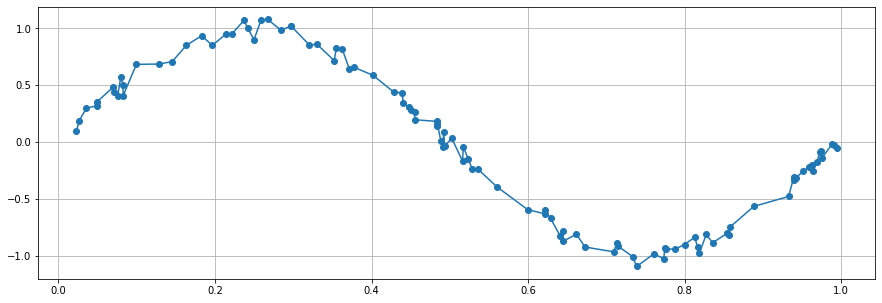

In [78]:
samples = 100
x = np.random.uniform(low=0.0, high=1.0, size=samples)
x = np.sort(x, axis=0)
x_copy = np.copy(x)

noise = np.random.uniform(low=-0.1, high=0.1, size=samples)
y = np.sin(2 * np.pi * x)  + noise
 
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x, y, '-o')
ax.grid() ; plt.show() 


## 3. Algoritmul K-means

K-means este folosit pentru construcţia centroizilor. Acolo vom 'centra' cele K gaussiene.

1. se aleg cei K centri aleator dintre cele 100 de puncte existente
2. calculează distanţa de la fiecare punct la fiecare dintre cei K centroizi
3. pentru fiecare punct, se găseşte cel mai apropiat centroid de punctul respectiv
4. pentru fiecare din cei K centroizi, se recalculează media cluster-ului ca fiind media punctelor celor mai apropiate de acel centroid
5. centroidul devine media astfel calculată
6. repetă paşii 2 - 5 până când centroizii au o deplasare sub $10^{-6}$

Algoritmul K-means va întoarce centroizii împreună cu deviaţia standard a fiecărui cluster, asociat acelui centroid.

Dacă există clustere cu mai puţin de doi reprezentanţi, deviaţia standard ($\sigma$) a acelui cluster va fi calculată ca media deviaţiilor standard ale clusterelor care nu se află în această situaţie.

In [79]:
def kmeans(x, k):
    centroids = np.random.choice(x, size = k)
    previousCenters = centroids.copy()
    standard_deviation = np.zeros(k)
    converged = False
    
    while not converged:
        dist = np.abs(x.reshape(len(x),1) -  centroids.reshape(1, len(centroids)))
        nextClosestCenter = np.argmin(dist, axis = 1)
        
        for i in range(k):
            pointsCenters = x[nextClosestCenter == i]
            if len(pointsCenters) >0:
                centroids[i] = np.mean(pointsCenters, axis = 0)
        converged = np.linalg.norm(centroids - previousCenters) < 1e-6
        previousCenters = centroids.copy()
        
    dist = np.abs(x.reshape(len(x),1) -  centroids.reshape(1, len(centroids)))
    nextClosestCenter = np.argmin(dist, axis=1)
 
    pointlessCentroids = []
    for i in range(k):
        pointsCenter= x[nextClosestCenter == i]
        if len(pointsCenter) < 2:
            pointlessCentroids.append(i)
            continue
        else:
            standard_deviation[i] = np.std(x[nextClosestCenter == i])
 
    if len(pointlessCentroids) > 0:
        averagePoints = []
        for i in range(k):
            if i not in pointlessCentroids:
                averagePoints.append([nextClosestCenter == i])
        averagePoints = np.concatenate(averagePoints).reshape(-1,1)
        standard_deviation[pointlessCentroids] = np.mean(np.std(averagePoints))
 
            
    return centroids, standard_deviation

In [80]:
k = 50
centers, standard_deviation = kmeans(x, k)

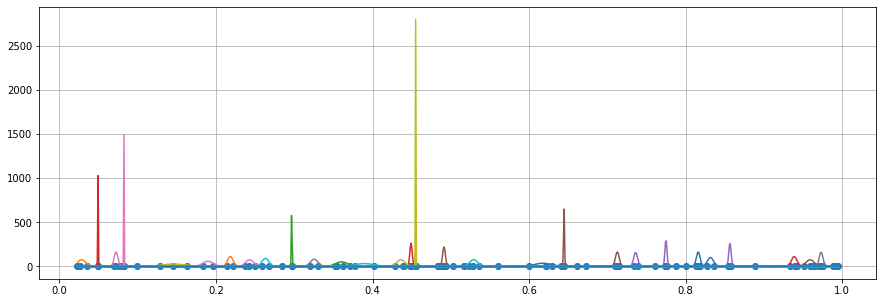

In [81]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x, np.zeros_like(x), '-o')
v = np.linspace(x.min(), x.max(), 1000)
for i in range(k):
    ax.plot(v, stats.norm.pdf(v, loc=centers[i], scale=standard_deviation[i]))
ax.grid() ; plt.show() 

Observaţi cum apar mai multe gaussiene în zonele cu puncte mai dese. Încercaţi să modificaţi numărul de clustere.

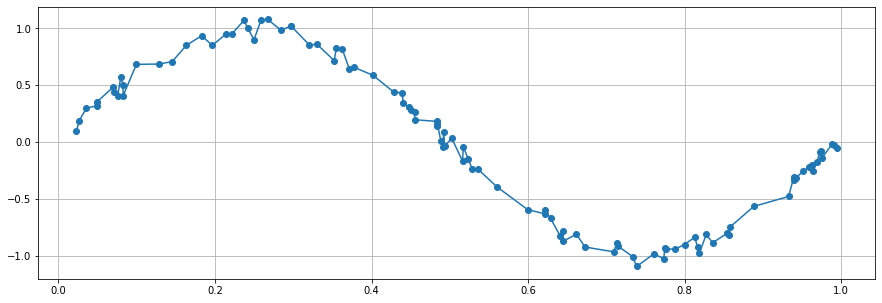

In [82]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x, y, '-o')
ax.grid() ; plt.show() 

In [83]:
def rbf(x, c, sigma):
    return np.exp(- (x - c) ** 2 / (2 * sigma ** 2))

## 4. Instruirea ponderilor stratului ascuns

Realizaţi, în fiecare epocă, parcurgerea sample cu sample. Pentru fiecare sample $x^{(i)}$ astfel ales, calculaţi valoarea activării (funcţia $f(\cdot)$), loss-ului şi a lui delta.

In [84]:
learning_rate = 0.05
epochs = 200
weights = np.random.randn(k)
biases = np.random.randn(1)

for epoch in range(epochs):
    for i in range(len(x)):
        activations = np.array([rbf(x[i], center, s) for center, s, in zip(centers, standard_deviation)])
        activation_value_function = np.transpose(activations.dot(weights)) + biases
        loss = (y[i] - activation_value_function) ** 2
        delta = -(y[i] - activation_value_function)
        
        weights += - learning_rate * activations * delta
        biases += - learning_rate * delta

Definiţi funcţia de inferenţă, de calcul a activării pentru fiecare element, $y\_pred^{(i)} = f(x^{(i)})$.

In [85]:
def inference(x):
    y_pred = []
    for i in range(len(x)):
        activations = np.array([rbf(x[i], center, s) for center, s, in zip(centers, standard_deviation)])
        activation_value_function = np.transpose(activations.dot(weights)) + biases
        y_pred.append(activation_value_function)
        
    return np.array(y_pred)

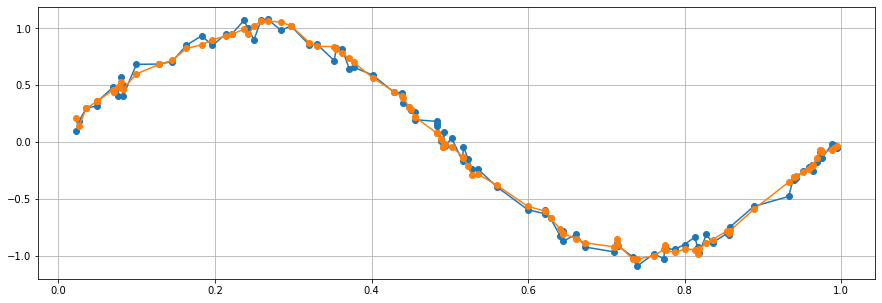

In [86]:
y_pred = inference(x)

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x, y, '-o')
ax.plot(x, y_pred, '-o')
ax.grid() ; plt.show() 

## 5. Fine-tuning

Realizaţi:
* regularizarea ponderilor stratului ascuns
* modificaţi numărul de clustere K şi găsiţi cea mai bună valoare
* găsiţi cel mai bun parametru de regularizare şi cea mai bună rată de învăţare

# 5.1 Regularizarea ponderilor stratului ascuns

In [87]:
lmbda = 0.01
func = lambda x: lmbda/2 * x*x
fderiv = lambda x: lmbda*x
for epoch in range(epochs):
    for i in range(len(x)):
        activations = np.array([rbf(x[i], center, s) for center, s, in zip(centers, standard_deviation)])
        activation_value_function = np.transpose(activations.dot(weights)) + biases
        loss = (y[i] - activation_value_function) ** 2 - func(weights)
        delta = -(y[i] - activation_value_function)
        weights += -learning_rate * activations * delta - fderiv(weights)
        biases += -learning_rate * delta       

# 5.2 Modificarea numărului de clustere K şi gasirea celei mai bune valoari

In [88]:
min_value = 99999

for index in range(1, 50):
    weights = np.random.randn(index)
    biases = np.random.randn(1)
    centers, standard_deviation = kmeans(x_copy, index)
    for epoch in range(10):
        for i in range(len(x)):
            activations = np.array([rbf(x[i], center, s) for center, s, in zip(centers, standard_deviation)])
            activation_value_function = np.transpose(activations.dot(weights)) + biases
            loss = (y[i] - activation_value_function) ** 2
            delta = -(y[i] - activation_value_function)
            weights += - learning_rate * activations * delta
            biases += - learning_rate * delta
    if min(loss)<min_value:
        min_pos = index
        min_value = min(loss)

print(min_pos)
print( "%.16f" % float(min_value))

36
0.0000225999983897


# 5.3 Găsirea celui mai bun parametru de regularizare şi cea mai bună rată de învăţare

In [89]:
min_value = 99999

for learningRate in np.arange(0, 0.1, 0.01):
    for epoch in range(epochs):
        for i in range(len(x)):
            activations = np.array([rbf(x[i], center, s) for center, s, in zip(centers, standard_deviation)])
            activation_value_function = np.transpose(activations.dot(weights)) + biases
            loss = (y[i] - activation_value_function) ** 2
            delta = -(y[i] - activation_value_function)
            weights += -learningRate * activations * delta
            biases += -learningRate * delta
            if min(loss)<min_value:
                min_learning_rate = learningRate
                min_value = min(loss)

print( "%.16f" % float(min_value))
print(min_learning_rate)

0.0000000000010788
0.01
